<div dir="rtl">
<font size=5 color="crimson">
توجه: لطفا اول نوت‌بوک GetRotkText را ران کنید چون آن نوت‌بوک فایل‌هایی می‌سازد که نوت‌بوک حاضر به آن نیاز دارد.
</font>
</div>

In [ ]:
# Cell 1

%%shell
python3 -m pip install unidecode
python3 -m pip install krovetzstemmer

In [ ]:
# Cell 2

# import time
import pandas as pd
import json
from unidecode import unidecode
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
# from nltk.stem import SnowballStemmer, LancasterStemmer, WordNetLemmatizer
import krovetzstemmer
from collections import defaultdict, OrderedDict

import numpy as np
# from sklearn.preprocessing import normalize
# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 12]
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Cell 3

def english_chinese(name):
    chinese = ""
    english = ""
    display_friendly = ""
    words = name.replace("/", " ").split(" ")
    if len(words) < 3:
        english = words[0]
        display_friendly = words[0]
        if len(words) > 1:
            chinese = words[1]
    else:
        english = "".join(words[:2]).strip()
        chinese = "".join(words[2:]).strip()
        display_friendly = " ".join(words[:2]).strip()
    english = unidecode(english).lower()
    return english, {english: unidecode(display_friendly)}, chinese


In [ ]:
# Cell 4

with open('Sanguo Yanyi.json') as f_in:
    story = json.load(f_in)
story = {k:v for k, v in story.items() if k in ["Chapter " + str(i) for i in range(1, 121)]}
characters = pd.read_excel("SanguoYanyiChars.xlsx")
english_names, display_friendly_names, chinese_names = zip(*characters["Name"].map(english_chinese))
english_names = list(set(english_names))
display_friendly_names = {k: v for d in display_friendly_names for k, v in d.items()}


<div dir="rtl">
<font size=5 color="navy">
قسمت ۱:  ساخت feature vector با استفاده از همزمانی n-gramها در پنجره‌ها (سلول‌های ۵ تا ۱۲)
</font>
</div>

In [ ]:
# Cell 5

stemmer = krovetzstemmer.Stemmer()
# lemmatizer = WordNetLemmatizer()
ngram_relations = defaultdict(int)
frequencies = defaultdict(int)
def process_string(s, window_size=10, ngram_max_n=3, is_stemmed=False):
    global ngram_relations, frequencies, english_names, stemmer  #, start_time
    temp = unidecode(s)
    temp = temp.lower()
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    temp = temp.translate(translator)
    templ = [word for word in temp.split() if not word in stopwords.words("english")]
    # find character names
    templ_c = []
    i = 0
    while i < len(templ) - 1:
        possible_fullname = templ[i] + templ[i + 1]
        if possible_fullname in english_names:
            templ_c.append(possible_fullname)
            i += 2
        else:
            if is_stemmed:
                templ_c.append(stemmer.stem(templ[i]))
            else:
                templ_c.append(templ[i])
            i += 1
    templ = templ_c
    text_length = len(templ)
    for i in range(text_length):
        for j in range(1, ngram_max_n + 1):
            current_ngram = " ".join(templ[i: i + j]).strip()
            frequencies[current_ngram] += 1
            for distance in range(1, window_size):
                if i + distance < text_length:
                    for k in range(1, ngram_max_n + 1):
                        if i + distance + k <= text_length:
                            adjacent_ngram = " ".join(templ[i + distance: i + distance + k]).strip()
                            if current_ngram != adjacent_ngram:
                                ngram_relations[frozenset([current_ngram, adjacent_ngram])] += 1
        # if i % 1000 == 0:
        #     print(i, "time = ", time.time() - start_time)
    return True

<div dir="rtl">
<font size=5 color="navy">
۱ الف - بدست آوردن و نمایش بردار ویژگی برای شخصیت‌های داستان (سلول ۶ تا ۹)
</font>
</div>

In [ ]:
# Cell 6

# start_time = time.time()
for chapter, content in story.items():
    title = content["title"]
    text = content["text"]
    a = process_string(title)
    b = process_string(text)

# vals = list(frequencies.values())
# vals.sort()
minn = 10 # vals[int(len(vals) * 0.05)]

def filter_good_frequencies(ngramset):
    global frequencies, minn #, vals
    for word in ngramset:
        if frequencies[word] <= minn:
            return False
    return True


ngram_relations = {k: v for k, v in ngram_relations.items() if filter_good_frequencies(k)}
names = [name for name in english_names if frequencies[name] > minn * 5]

In [ ]:
# Cell 7

feature_words = set()
name_set = set(names)
for k, v in ngram_relations.items():
    if v > 10:
        print(frozenset(map(lambda key: display_friendly_names[key] if key in display_friendly_names.keys() else key, list(k))), v)
    if len(k.intersection(name_set)) > 0:
        for word in k:
            feature_words.add(word)
print("Length of the Feature Vector for each Word", len(feature_words))
feature_words = list(feature_words)

indices = {}
texts = []
vecs = np.zeros((len(names), len(feature_words)))

degree = {name:0 for name in names}
for k, v in ngram_relations.items():
    kp = list(k)
    if kp[0] in names and kp[1] in names:
        degree[kp[0]] += 1
        degree[kp[1]] += 1
print("Num of Related People for Each Person:", degree)

names_indices_to_keep = []
for i, name in enumerate(names):
    indices[i] = display_friendly_names[name]
    texts.append(display_friendly_names[name])
    for j in range(len(feature_words)):
        if name == feature_words[j]:
            vecs[i][j] = 1000
        elif frozenset([name, feature_words[j]]) in ngram_relations.keys():
            vecs[i][j] = ngram_relations[frozenset([name, feature_words[j]])]
    if degree[name] > 5:
        names_indices_to_keep.append(i)

# vecs = normalize(vecs, axis=0, norm="l1")
vecs = vecs[names_indices_to_keep, :]
names = [names[i] for i in names_indices_to_keep]
texts = [texts[i] for i in names_indices_to_keep]

Streaming output truncated to the last 5000 lines.
frozenset({'shall', 'defeat'}) 15
frozenset({'remain', 'Guan Yu'}) 11
frozenset({'Xiahou Dun', 'Guan Yu'}) 23
frozenset({'challenge', 'troops'}) 12
frozenset({'away', 'thousand troops'}) 13
frozenset({'Guan Yu', 'drew'}) 17
frozenset({'bomb', 'troops'}) 11
frozenset({'left right', 'right'}) 13
frozenset({'way', 'arrows'}) 13
frozenset({'road', 'turned'}) 16
frozenset({'joined', 'city'}) 11
frozenset({'hill', 'Guan Yu'}) 11
frozenset({'hill', 'sides'}) 11
frozenset({'enemy', 'order'}) 25
frozenset({'Guan Yu', 'indeed'}) 13
frozenset({'Guan Yu', 'night'}) 14
frozenset({'within', 'saw'}) 14
frozenset({'presently', 'come'}) 12
frozenset({'Zhang Liao', 'fight'}) 14
frozenset({'elder', 'younger'}) 12
frozenset({'brother', 'hands'}) 12
frozenset({'dead', 'night'}) 12
frozenset({'people', 'night'}) 21
frozenset({'tell', 'set'}) 12
frozenset({'escape', 'came'}) 13
frozenset({'yet', 'Guan Yu'}) 14
frozenset({'look', 'Guan Yu'}) 15
frozenset({'be

In [ ]:
# Cell 8

def plot_vectors():
    global vecs, names, texts
    # pca = PCA(n_components=2)
    # reduced = pca.fit_transform(vecs)
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(vecs)
    t = reduced.transpose()
    # tprim = t
    selected_indices = [i for i in range(len(t[0]))] # if t[0][i] < 250 and t[1][i] > -100 and t[1][i] < 100]
    tprim = t[:, selected_indices]
    names = [names[i] for i in selected_indices]
    texts = [texts[i] for i in selected_indices]
    plt.scatter(tprim[0], tprim[1], s=[frequencies[name]/5 for name in names])
    for i, txt in enumerate(texts):
        plt.annotate(txt, (tprim[0][i], tprim[1][i]))
    plt.show()
    return True

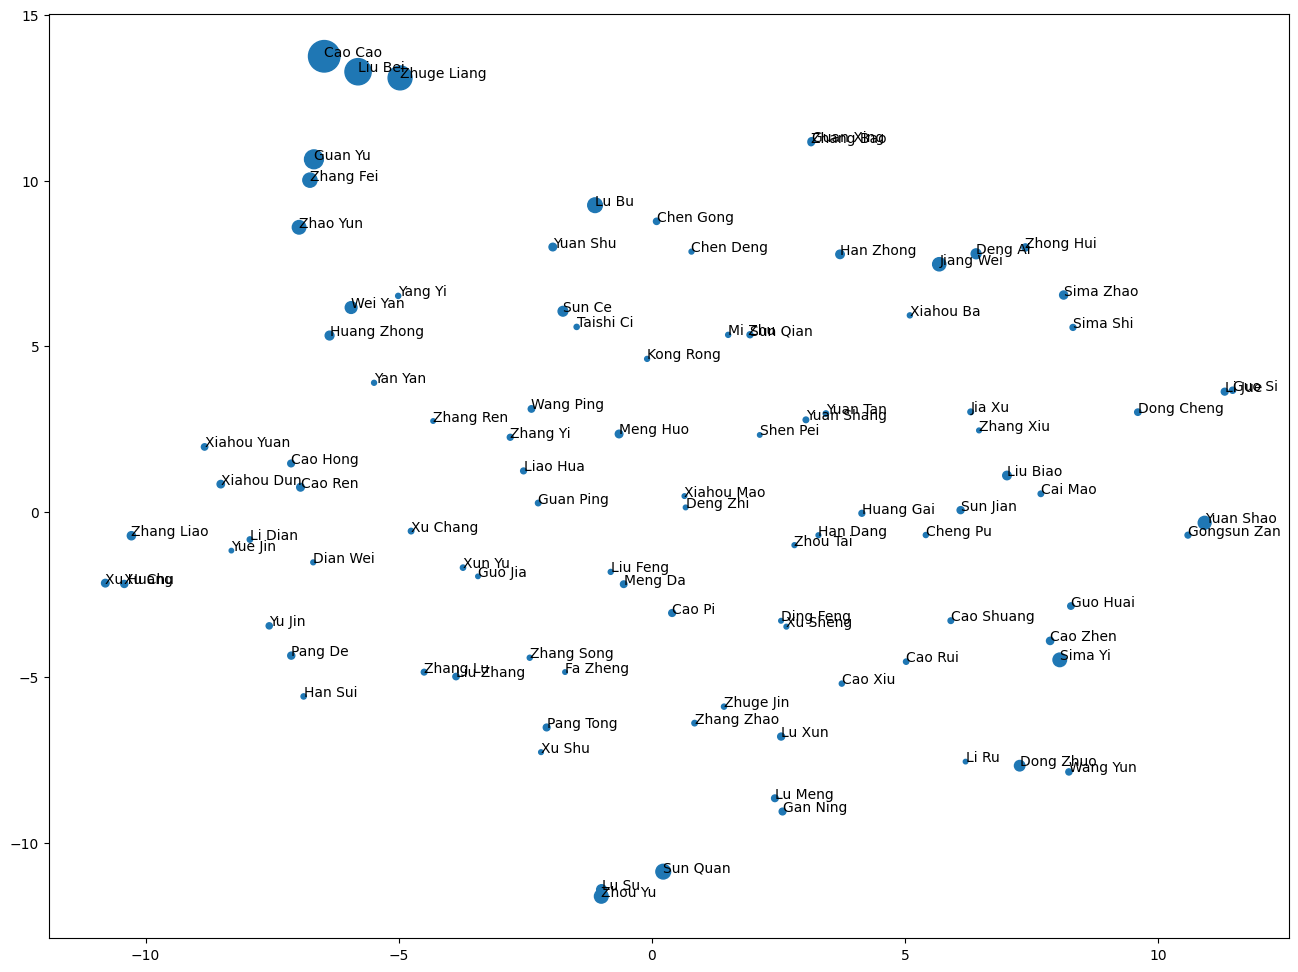

True

In [ ]:
# Cell 9

plot_vectors()

<div dir="rtl">
<font size=5 color="navy">
۱ ب - بدست آوردن و نمایش بردار ویژگی برای اسامی عام (سلول ۶ تا ۹)
</font>
</div>

In [ ]:
# Cell 10

ngram_relations = defaultdict(int)
frequencies = defaultdict(int)

# start_time = time.time()
for chapter, content in story.items():
    title = content["title"]
    text = content["text"]
    # CHANGES FOR NON-NAME MODE 1
    a = process_string(title, is_stemmed=True)
    b = process_string(text, is_stemmed=True)

# vals = list(frequencies.values())
# vals.sort()
minn = 10 # vals[int(len(vals) * 0.05)]

ngram_relations = {k: v for k, v in ngram_relations.items() if filter_good_frequencies(k)}
names = english_names

In [ ]:
# Cell 11

feature_words = set()
name_set = set(names)
for k, v in ngram_relations.items():
    if v > 10:
        print(frozenset(map(lambda key: display_friendly_names[key] if key in display_friendly_names.keys() else key, list(k))), v)

    # CHANGES FOR NON-NAME MODE 2
    # if len(k.intersection(name_set)) > 0:
    for word in k:
        # CHANGES FOR NON-NAME MODE 3
        if frequencies[word] > 200 and len(word) > 2:
            feature_words.add(word)
print("Length of the Feature Vector for each Word", len(feature_words))
feature_words = list(feature_words)

# CHANGES FOR NON-NAME MODE 4
names = [word for word in feature_words if not word in names]
display_friendly_names = {word:word for word in names}

indices = {}
texts = []
vecs = np.zeros((len(names), len(feature_words)))

degree = {name:0 for name in names}
for k, v in ngram_relations.items():
    kp = list(k)
    if kp[0] in names and kp[1] in names:
        degree[kp[0]] += 1
        degree[kp[1]] += 1
print("Num of Related People for Each Thing:", degree)

names_indices_to_keep = []
for i, name in enumerate(names):
    indices[i] = display_friendly_names[name]
    texts.append(display_friendly_names[name])
    for j in range(len(feature_words)):
        if name == feature_words[j]:
            vecs[i][j] = 1000
        elif frozenset([name, feature_words[j]]) in ngram_relations.keys():
            vecs[i][j] = ngram_relations[frozenset([name, feature_words[j]])]
    # CHANGES FOR NON-NAME MODE 5
    if degree[name] > 5 and len(name.strip().split(" ")) == 1: # and frequencies[name] > 200
        names_indices_to_keep.append(i)

# vecs = normalize(vecs, axis=0, norm="l1")
vecs = vecs[names_indices_to_keep, :]
names = [names[i] for i in names_indices_to_keep]
texts = [texts[i] for i in names_indices_to_keep]

Streaming output truncated to the last 5000 lines.
frozenset({'territory', 'saying'}) 11
frozenset({'three river', 'river'}) 27
frozenset({'river', 'lands'}) 51
frozenset({'Sun Quan', 'must'}) 24
frozenset({'Sun Quan', 'saying'}) 32
frozenset({'Sun Quan', 'hand'}) 16
frozenset({'wu', 'hand'}) 14
frozenset({'Sun Quan', 'might'}) 11
frozenset({'make', 'Sun Quan'}) 18
frozenset({'force', 'Sun Quan'}) 18
frozenset({'wu', 'might'}) 11
frozenset({'make', 'wu'}) 13
frozenset({'force', 'wu'}) 19
frozenset({'land', 'get'}) 24
frozenset({'land', 'take'}) 34
frozenset({'good', 'succeed'}) 12
frozenset({'take', 'father'}) 14
frozenset({'Sun Quan', 'father'}) 13
frozenset({'Sun Quan', 'take'}) 28
frozenset({'Sun Quan', 'good'}) 17
frozenset({'Sun Quan', 'turn'}) 20
frozenset({'given', 'brother'}) 12
frozenset({'may', 'young'}) 12
frozenset({'know', 'able'}) 17
frozenset({'must', 'Zhou Yu'}) 27
frozenset({'turn', 'Zhou Yu'}) 19
frozenset({'matter', 'Zhou Yu'}) 13
frozenset({'cannot', 'Zhou Yu'}) 11


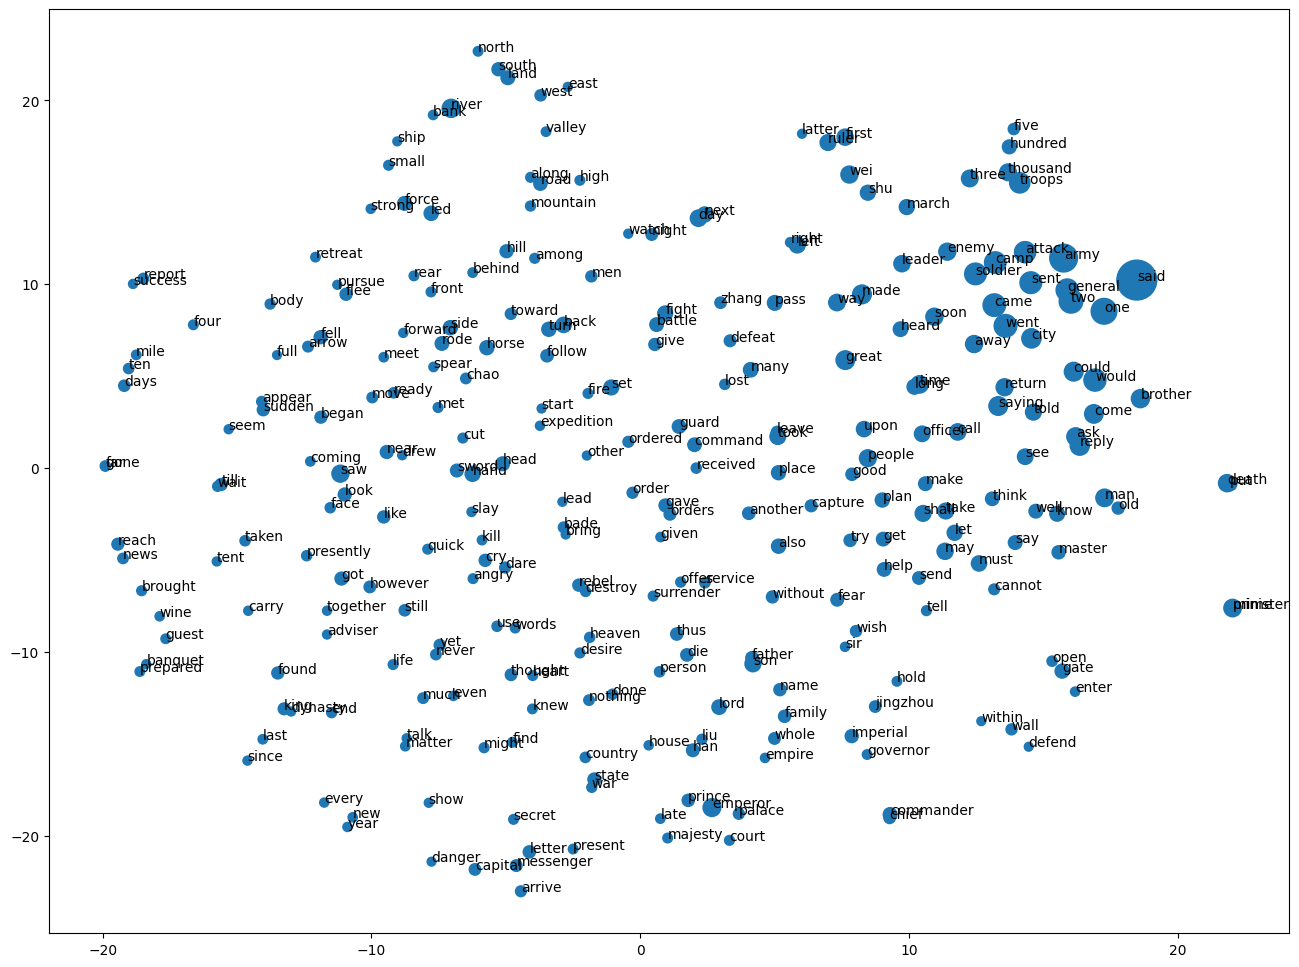

True

In [ ]:
# Cell 12

plot_vectors()

<div dir="rtl">
<font size=5 color="navy">
قسمت ۲:  ساخت feature vector با استفاده از مدل word2vec از کتابخانه gensim (سلول‌های ۱۳ تا ۱۸)
</font>
</div>

In [ ]:
# Cell 13

import gensim

In [ ]:
# Cell 14

frequencies = defaultdict(int)
stemmer = krovetzstemmer.Stemmer()
def tokenize(s, is_stemmed=False):
    global frequencies, title_frequency_weight
    temp = unidecode(s)
    temp = temp.lower()
    # map punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    temp = temp.translate(translator)
    templ = [word for word in temp.split() if not word in stopwords.words("english")]
    # find character names
    templ_c = []
    i = 0
    while i < len(templ) - 1:
        possible_fullname = templ[i] + templ[i + 1]
        if possible_fullname in english_names:
            templ_c.append(possible_fullname)
            i += 2
        else:
            if is_stemmed:
                templ_c.append(stemmer.stem(templ[i]))
            else:
                templ_c.append(templ[i])
            i += 1
    templ = templ_c
    # stemmer = SnowballStemmer(language='english')
    # lemmatizer = WordNetLemmatizer()
    # templ = [stemmer.stem(word) for word in templ]
    for word in templ:
        frequencies[word] += 1
    return templ

<div dir="rtl">
<font size=5 color="navy">
۲ الف - بدست آوردن و نمایش بردار ویژگی برای شخصیت‌های داستان (سلول‌های ۱۵ و ۱۶)
</font>
</div>

In [ ]:
# Cell 15

tokenized = {}
for chapter, content in story.items():
    title = content["title"]
    text = content["text"]
    tokenized[chapter] = tokenize(title) + tokenize(text)

print("tokenized[\"Chapter 48\"]", tokenized["Chapter 48"])

num_of_features = 200
w2v = gensim.models.Word2Vec([chapter for chapter in tokenized.values()], min_count = 10,
                                                vector_size = num_of_features, window = 20)
frequencies = OrderedDict(sorted(frequencies.items(), key=lambda v: v, reverse=True))

indices = {}
texts = []
english_names, display_friendly_names, chinese_names = zip(*characters["Name"].map(english_chinese))
display_friendly_names = {k: v for d in display_friendly_names for k, v in d.items()}
names = list(set([name for name in english_names if name in w2v.wv.key_to_index.keys() and frequencies[name] > 50]))
vecs = np.zeros((len(names), num_of_features))

for i, name in enumerate(names):
    indices[i] = display_friendly_names[name]
    texts.append(display_friendly_names[name])
    vecs[i] = w2v.wv[name]

tokenized["Chapter 48"] ['banquet', 'great', 'river', 'caocao', 'sings', 'song', 'battle', 'water', 'northern', 'soldiers', 'fight', 'chained', 'last', 'chapter', 'pangtong', 'brought', 'sudden', 'shock', 'someone', 'seized', 'spoke', 'scheme', 'upon', 'turning', 'look', 'man', 'pangtong', 'saw', 'xushu', 'old', 'friend', 'heart', 'revived', 'looking', 'around', 'seeing', 'one', 'near', 'pangtong', 'said', 'would', 'pity', 'upset', 'plan', 'fate', 'people', 'eighty', 'one', 'southern', 'counties', 'hands', 'xushu', 'smiled', 'saying', 'fate', 'eight', 'hundred', 'thirty', 'thousand', 'soldiers', 'horse', 'north', 'intend', 'wreck', 'scheme', 'xushu', 'never', 'forgotten', 'kindness', 'uncle', 'liubei', 'oath', 'avenge', 'death', 'mother', 'caocao', 'hands', 'said', 'would', 'never', 'think', 'plan', 'likely', 'wreck', 'brother', 'followed', 'caocao', 'army', 'thus', 'far', 'shall', 'defeated', 'good', 'bad', 'suffer', 'alike', 'escape', 'tell', 'secure', 'safety', 'sew', 'lips', 'go', 

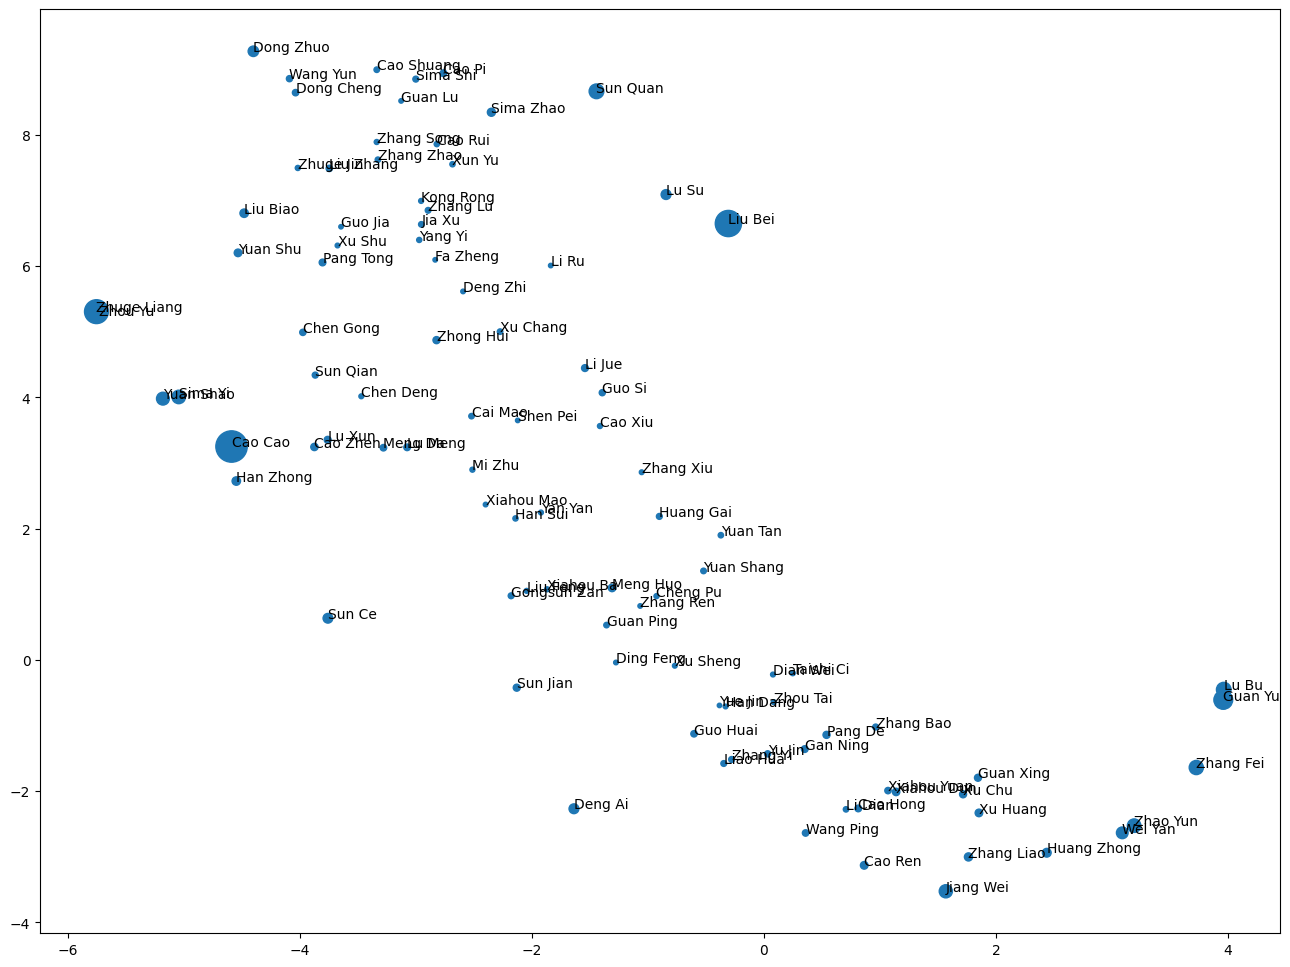

True

In [ ]:
# Cell 16

plot_vectors()

<div dir="rtl">
<font size=5 color="navy">
۲ ب - بدست آوردن و نمایش بردار ویژگی برای اسامی عام (سلول‌های ۱۷ و ۱۸)

</font>
</div>

In [ ]:
# Cell 17

tokenized = {}
frequencies = defaultdict(int)

for chapter, content in story.items():
    title = content["title"]
    text = content["text"]
    # CHANGED FOR NON-NAME MODE 1
    tokenized[chapter] = tokenize(title, is_stemmed=True) + tokenize(text, is_stemmed=True)

print("tokenized[\"Chapter 48\"]", tokenized["Chapter 48"])

num_of_features = 200
w2v = gensim.models.Word2Vec([chapter for chapter in tokenized.values()], min_count = 10,
                                                vector_size = num_of_features, window = 20)
frequencies = OrderedDict(sorted(frequencies.items(), key=lambda v: v, reverse=True))

indices = {}
texts = []
# CHANGED FOR NON-NAME MODE 2
names = list(set([name for name in w2v.wv.key_to_index.keys() if not name in english_names and frequencies[name] > 200]))
vecs = np.zeros((len(names), num_of_features))

for i, name in enumerate(names):
    indices[i] = name
    texts.append(name)
    vecs[i] = w2v.wv[name]

tokenized["Chapter 48"] ['banquet', 'great', 'river', 'caocao', 'sing', 'song', 'battle', 'water', 'northern', 'soldier', 'fight', 'chain', 'last', 'chapter', 'pangtong', 'brought', 'sudden', 'shock', 'someone', 'seize', 'spoke', 'scheme', 'upon', 'turning', 'look', 'man', 'pangtong', 'saw', 'xushu', 'old', 'friend', 'heart', 'revive', 'look', 'around', 'seeing', 'one', 'near', 'pangtong', 'said', 'would', 'pity', 'upset', 'plan', 'fate', 'people', 'eighty', 'one', 'southern', 'county', 'hand', 'xushu', 'smile', 'saying', 'fate', 'eight', 'hundred', 'thirty', 'thousand', 'soldier', 'horse', 'north', 'intend', 'wreck', 'scheme', 'xushu', 'never', 'forgotten', 'kindness', 'uncle', 'liubei', 'oath', 'avenge', 'death', 'mother', 'caocao', 'hand', 'said', 'would', 'never', 'think', 'plan', 'likely', 'wreck', 'brother', 'follow', 'caocao', 'army', 'thus', 'far', 'shall', 'defeat', 'good', 'bad', 'suffer', 'alike', 'escape', 'tell', 'secure', 'safety', 'sew', 'lip', 'go', 'away', 'pangtong', 

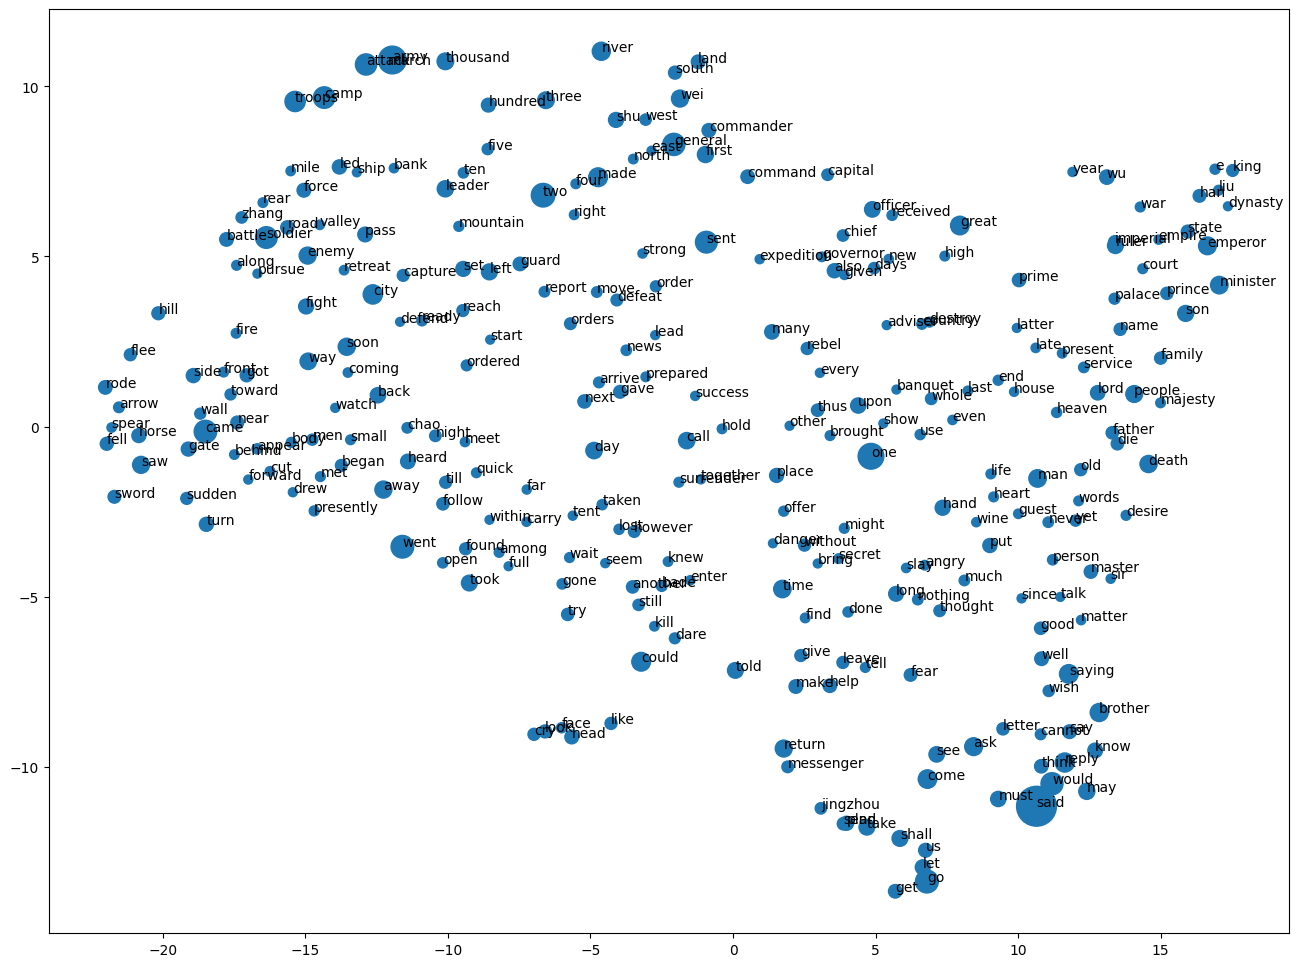

True

In [ ]:
# Cell 18

plot_vectors()